In [1]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.cuore_thermalmodeldata

import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import *
import scipy
from scipy import signal
import scipy.optimize

In [2]:
#apply bessel filters to simulated pulse
def bessel_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.bessel(order, normal_cutoff, btype='low', analog=False)
    return b, a

def bessel_lowpass_filter(data):
    sampling = 8
    dur = 1e-3
    cutoff = 18
    samplingRate = 1.0/(sampling*dur)
    order = 6
    b, a = bessel_lowpass(cutoff, samplingRate, order)
    y = signal.filtfilt(b, a, data)
    return y

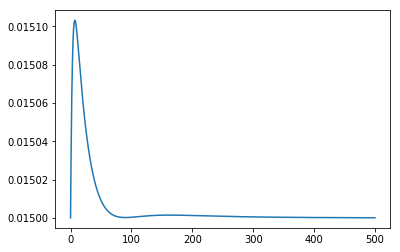

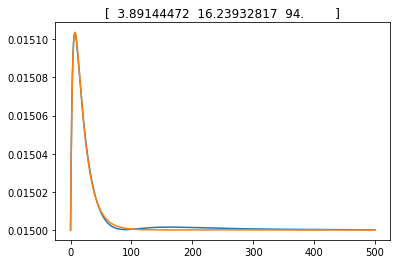

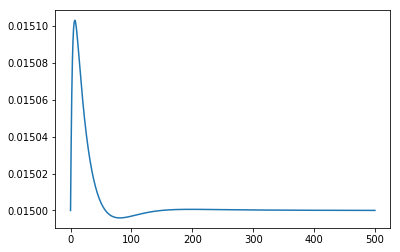

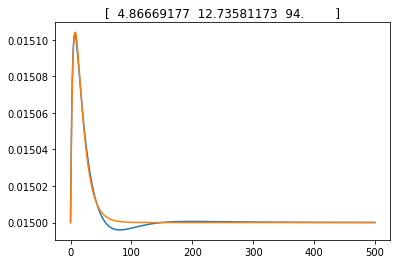

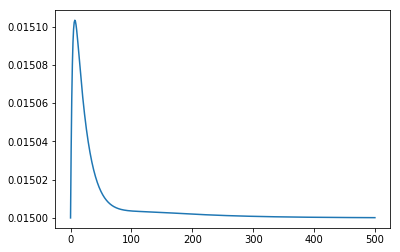

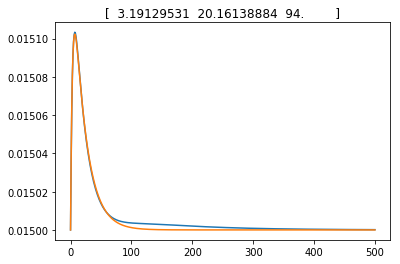

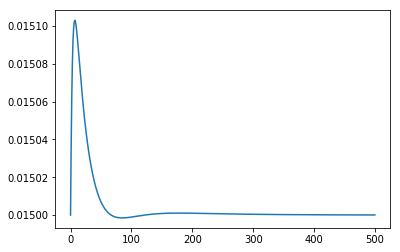

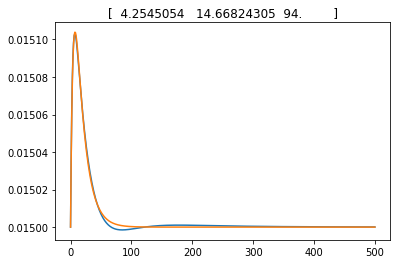

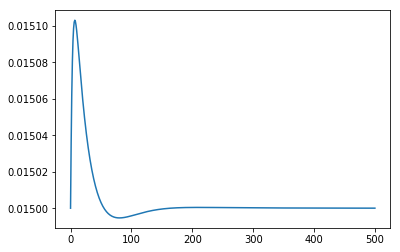

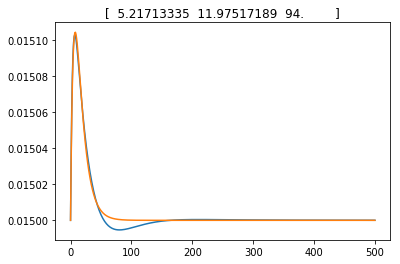

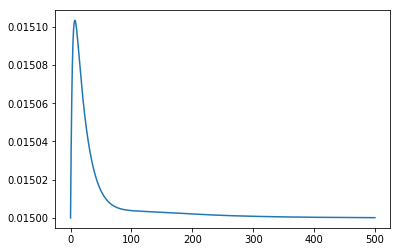

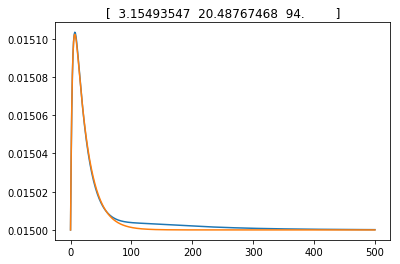

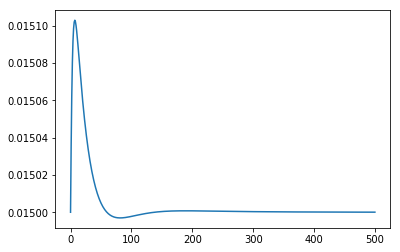

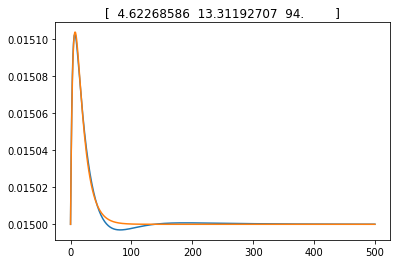

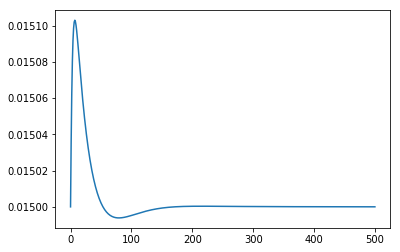

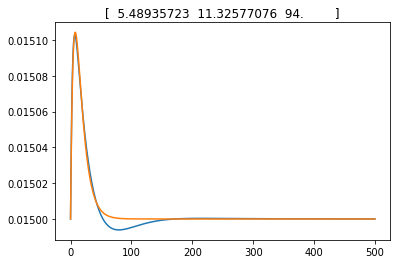

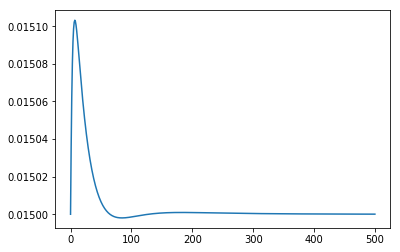

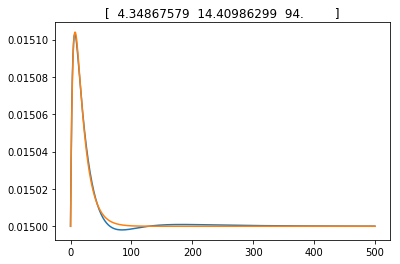

In [17]:
cursor = db.testdata.find({'model_info.test_number':1})

r0_array, t0_array, t1,t2,t3 = [],[],[],[],[]

def expFit(x,a,b,t1,t2,t3):
    return a*(-1*np.exp(-1*np.divide(x,t1))+b*np.exp(-1*np.divide(x,t2))+(1-b)*np.exp(-1*np.divide(x,t2)))+0.015

for document in cursor:
    s = document["thermal_parameters"]["s"]
    r0 = document["thermal_parameters"]["R0"]
    t0 = document["thermal_parameters"]["T0"]
    b = (document["data"]["b"])
    v = (document["data"]["f"])

    r = r0*np.exp(np.power(np.divide(t0,b),(0.5)))

    i = np.divide(v,r)
    
    plt.figure()
    plt.plot(b[125:])
    plt.figure()
    plt.plot(b[125:])
    
    try:
        popt, pcov = scipy.optimize.curve_fit(expFit,range(0,501),b[125:], (0.0001,0.9,2.6,20,94)) 
        plt.plot(range(0,501), expFit(range(0,501), *popt))
        r0_array.append(r0)
        t0_array.append(t0)
        plt.title(popt[2:])
        t1.append(popt[2])
        t2.append(popt[3])
        t3.append(popt[4])
        
    except:
        print('Fit Failed')

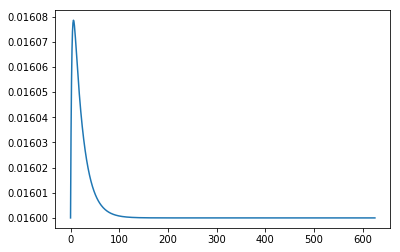

In [91]:
def expFit(x,a,b,t1,t2,t3,d):
    return a*(-1*np.exp(-1*np.divide(x,t1))+b*np.exp(-1*np.divide(x,t2))+(1-b)*np.exp(-1*np.divide(x,t2)))+d

a = 0.00012346
b = 0.91533
t1 = 0.020897*125
t2 = 0.1572*125
t3 = 0.7487*125
d = 0.016

x = range(0,626)
y = expFit(x,a,b,t1,t2,t3,d)
plt.plot(x,y)

In [95]:
print [r0_array,t0_array,t1,t2,t3]

[[3.713143621307457, 2.468618507007107, 2.9602680689021468, 2.8090897506171597, 3.339490922727368, 3.256823910644209, 1.8320641673348599, 2.7670635494571156, 3.379980050707305], [5.491418357637254, 5.904597065180332, 5.457394326985373, 5.721711588506063, 5.787034806580264, 5.394593604462281, 6.035509083505946, 5.9313385892607435, 5.634862612104737], [3.9870210445775247, 4.773954020204588, 3.38173639632614, 4.2900888570541209, 5.0273440778140257, 3.3492629056009133, 4.5901078426356614, 5.2201489952015123, 4.3642693158210886], [15.855114659926405, 12.976651225646574, 19.011648782779076, 14.549062520773061, 12.415895853887946, 19.281673566649587, 13.404293737342238, 11.89531229367627, 14.359300272539111], [94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0]]
